# Домашнее задание №2 - Линейные модели. Градиентный спуск

В этом домашнем задании мы с вами научимся обучать линейные модели регрессии и классификации при помощи очень мощного, но в то же время довольно понятного алгоритма, который называется **градиетный спуск**. Помимо линейных моделей он используется и для обучения самых сложных нейронных сетей! Также мы потренируемся применять готовые реализации линейных моделей для задач регрессии и бинарной классификации.

In [356]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
import pandas as pd

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.exceptions import NotFittedError
from sklearn.linear_model import (LinearRegression,
                                  LogisticRegression)
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import (StandardScaler,
                                   OneHotEncoder,
                                   LabelEncoder)
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.metrics import (r2_score,
                             mean_squared_error)
from sklearn.model_selection import train_test_split

In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

#### Маленькое теоретическое отступление

Основное свойство антиградиента (-1 * градиент) &ndash; он указывает в сторону наискорейшего убывания функции в данной точке. Соответственно, будет логично стартовать из некоторой точки, сдвинуться в сторону антиградиента, пересчитать антиградиент и снова сдвинуться в его сторону и т.д. Запишем это более формально.

Пусть $w_0$ &ndash; начальный набор параметров (коэффициентов линейной модели) ((например, нулевой или сгенерированный из некоторого, случайного распределения)). Тогда обычный градиентный спуск состоит в повторении следующих шагов до сходимости:


$$
    w_{k + 1} = w_{k} - \eta \nabla_{w} Q(w_{k}),
$$

где $\nabla_{w} Q(w_{k})$ &ndash; градиент функции потерь в точке $w_k$, а $\eta$ &ndash; скорость обучения (learning rate).

Градиентный спуск обычно останавливают, когда прошло заданное максимальное количество итераций или когда графиент близок к нулю (т.е. наши параметры практически не меняются). Для реализации второго варианта считают норму градиента (по сути длину вектора). Это можно сделать несколькими способами:

$$
l1_{norm} = \sum{|w_i|}
$$

$$
l2_{norm} = \sum{(w_i)^{2}}
$$

Попробуем разобраться на простом примере. Рассмотрим функцию от двух переменных:
$f(x, y) = \sin^2 x + \sin^2 y$

In [3]:
def f(w):
    """
    :param w: np.array(np.float) вектор из 2-х элементов
    :return: np.float
    """
    
    return np.sum(np.sin(w)**2)

Обратите внимание, что $x$ - numpy-array вектор длины 2.

***Reminder:***  
Что мы хотим? Мы хотим найти минимум этой функции (в машинном обучении мы обычно хотим найти минимум **функции потерь**, например, MSE), а точнее найти $w_1$ и $w_2$ такие, что при них значение $f(w_1, w_2)$ минимально, то есть *точку экстремума*.  
  
Как мы будем искать эту точку? Используем методы оптимизации (в нашем случае - *минимизации*). Одним из таких методов и является **градиентный спуск**.

### Задание 1. Градиентный спуск для функции $f$ (1 балл)

Реализуйте функцию, которая будет осуществлять градиентный спуск для функции $f$:

*Примечание:* Вам нужно посчитать частные производные именно **аналитически** и **переписать их в код**, а не считать производные численно (через отношение приращения функции к приращению аргумента) -- в этих двух случаях могут различаться ответы, поэтому будьте внимательны.

In [56]:
def grad_f(w): 
    """
    Градиент функциии f, определенной выше.
        :param w: np.array[2]: float вектор из 2-х элементов
        :return: np.array[2]: float вектор из 2-х элементов
    """
    return np.array(np.sin(w * 2))

Проверим, что градиент принимает вектор из двух чисел и выдает на этой точке верное значение

In [58]:
assert np.allclose(grad_f(np.array([1, 2])), 
                   np.array([0.90929743, -0.7568025])), "Что-то не так!"

In [72]:
def grad_descent_2d(f, grad_f, lr, num_iter=100, x0=None):
    """
    Функция, которая реализует градиентный спуск в минимум для функции f от двух переменных. 
        :param f: скалярная функция двух переменных
        :param grad_f: функция, возвращающая градиент функции f (устроена как реализованная вами выше grad_f)
        :param lr: learning rate алгоритма
        :param num_iter: количество итераций градиентного спуска
        :return: np.array[num_iter, 2] пар вида (x, f(x))
    """
    
    w0 = np.random.random(2)

    # будем сохранять значения аргументов и значений функции 
    # в процессе град. спуска в переменную history
    history = []

    # итерация цикла == шаг градиентнго спуска
    curr_w = w0.copy()
    for iter_num in range(num_iter):
        entry = np.hstack((curr_w, f(curr_w)))
        history.append(entry)
    
        curr_w -= lr * grad_f(curr_w)

    return np.vstack(history)

Визуализируем точки градиентного спуска на 3D-графике нашей функции. Звездочками будут обозначены точки (тройки $w_1, w_2, f(w_1, w_2)$), по которым Ваш алгоритм градиентного спуска двигался к минимуму (Для того, чтобы написовать этот график, мы и сохраняли значения $cur\_w_1, cur\_w_2, f(cur\_w_1, cur\_w_2)$ в `steps` в процессе спуска).

Если у Вас правильно написана функция `grad_descent_2d`, то звездочки на картинке должны сходиться к одной из точек минимума функции. Вы можете менять начальные приближения алгоритма, значения `lr` и `num_iter` и получать разные результаты.

In [81]:
def gradient_desc_vis(f, grad_f, lr=0.1, num_iter=50):
    steps = grad_descent_2d(f, grad_f, lr=lr, num_iter=num_iter)
    
    X, Y = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))

    fig = plt.figure(figsize=(16, 10))
    ax = fig.add_subplot(projection="3d")

    zs = np.array([f(np.array([x,y]))
                  for x, y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)


    ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, zorder=2)

    ax.plot(xs=steps[:, 0], ys=steps[:, 1], zs=steps[:, 2],
            marker="*", markersize=20, zorder=3, 
            markerfacecolor="y", lw=3, c="black")

    ax.set_zlim(0, 5)
    ax.view_init(elev=60)
    plt.show()
    
    return steps

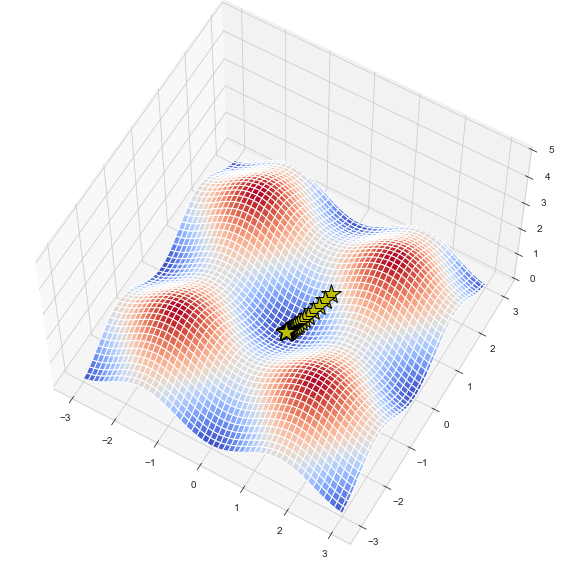

In [82]:
steps = gradient_desc_vis(f, grad_f)

Посмотрим на зависимость значения функции от шага градиентного спуска.

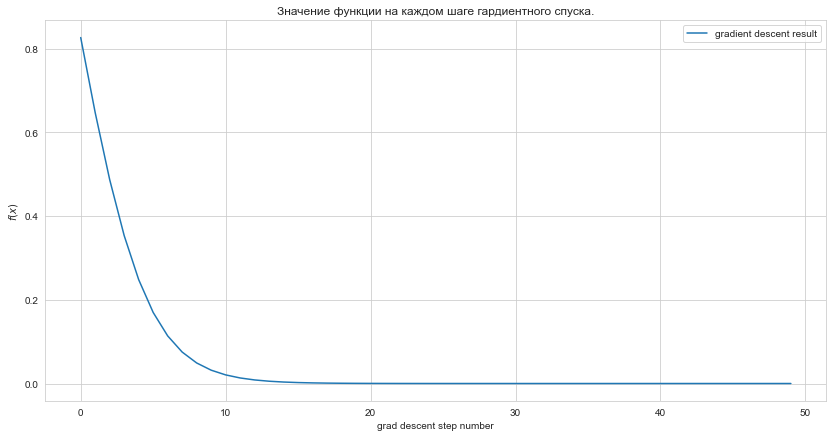

In [93]:
plt.figure(figsize=(14,7))
plt.xlabel("grad descent step number")
plt.ylabel("$f(x)$")
plt.title("Значение функции на каждом шаге гардиентного спуска.")

f_values = list(map(lambda x: x[2], steps))
plt.plot(f_values, label="gradient descent result")
plt.legend();

### Задание 2. Реализация линейной регресии (суммарно 9 баллов)

Так как мы будем использовать градиентный спуск для обучения модели, важной часть является реализация функции потерь и функции для расчета ее градиента. Перем началом стоит напомнить, как считать градиент MSE. Вывод этой формулы можно найти  [здесь](https://medium.com/analytics-vidhya/linear-regression-gradient-descent-intuition-and-math-c9a8f5aeeb22)

$$
    MSE = \frac{1}{N}\sum(y_{true} - y_{pred}) ^ 2
$$

$$
    \nabla{MSE} = \frac{2}{N} X^T (y_{pred} - y_{true})
$$

Здесь имеется в виду именно матричное умножение.

#### Задание 2.1. MSE и ее градиент (2 балла)

In [97]:
def mse(y_true, y_pred):
    """
    Функция потерь MSE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    return np.mean((y_true - y_pred) ** 2)


def mse_grad(y_true, y_pred, X):
    """
    Функция для расчета градиента MSE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели
        :param X: np.array[n_samples, n_features]: матрица объекты x признаки
        :return: градиент функции потерь MSE
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    """
    YOUR CODE IS HERE
    """
    
    return 2 / y_true.shape[0] * (X.transpose() @ (y_pred - y_true))


class MSELoss:
    """
    Класс, реализующий функцию потерь MSE. Нужен для того, чтобы
    объединять в одном месте функцию потерь и градиент для нее.
    """
    
    def __call__(self, y_true, y_pred):
        return mse(y_true, y_pred)
    
    def calculate_gradient(self, y_true, y_pred, X):
        return mse_grad(y_true, y_pred, X)

Мы будем использовать следующий класс для расчета градиента наших функций потерь:

In [98]:
class BasicGradientDescent:
    """
    Класс, позволяющий делать шаги градиентного спуска,
    а также рассчитывающих норму градиента.
    """
    
    def __init__(self, loss_function, grad_norm):
        self.loss = loss_function
        self.grad_norm = grad_norm
        
    
    def step(self, y, y_pred, X):
        grad_i = self.loss.calculate_gradient(y, y_pred, X)
        grad_i_norm = self._calculate_grad_norm(grad_i)
        
        return grad_i, grad_i_norm
            
            
    def _calculate_grad_norm(self, grad_i):
        if self.grad_norm == "l1":
            return np.abs(grad_i).sum()
        elif self.grad_norm == "l2":
            return np.sqrt(np.square(grad_i).sum())
        else:
            raise ValueError(f"I can't calculate {self.grad_norm} norm of gradient")

В данном задании нужно будет реализовать линейную регрессию и обучить ее при помощи градиентного спуска. Для этого нужно будет заполнять пропуски кода в соответствующих классах. Для начала мы реализуем базовый класс для всех линейных моделей, от которого потом будем наследоваться при реализации линейной и логистической регресий. Не переживайте, этот класс уже реализован, вам достостаточно просто разобраться с кодом.

In [99]:
class BaseLinearModel:
    """
    Класс, который представляет из себя базовую линейную модель, наследуюясь от которого, мы будем
    реализовывать линейную и логистическую регрессии.
    """
    
    def __init__(self, learning_rate, 
                 loss_function, fit_intercept,
                 n_iter, tol, optimizer, grad_norm):
        """
        Конструктор нашего класса. 
            :param learning_rate: скорость обучения
            :param loss_function: функция потерь (MSE или кросс-энтропия)
            :param fit_intercept: нужно ли нам включать свободных член в модель
            :param n_iter: количество итераций градиентного спуска
            :param tol: параметр для остановки градиентного спуска,
                        если норма градиента (l1 или l2) меньше tol, то останавливаемся
            :param optimizer: класс, который будет рассчитывать градиент и его норму
            :param grad_norm: тип нормы градиента l1 или l2
        """
        
        self.learning_rate = learning_rate
        self.loss = loss_function
        self.fit_intercept = fit_intercept
        self.n_iter = n_iter
        self.tol = tol
        self.grad_norm = grad_norm
        self.optimizer = optimizer(loss_function, grad_norm)
        
        # В начале параметры модели не заданы
        self.W = None
        
        
    def fit(self, X, y):
        """
        Метод для обучения нашей модели 
            :param X: матрица объекты x признаки
            :param y: вектор значений целевой переменной
            :return: обученная модель
        """
        
        # Сделаем из y вектор-столбец (n_samples, 1)
        y = y.reshape(-1, 1)
        n_samples = X.shape[0]
        
        # Добавим колонку из 1 в матрицу X
        if self.fit_intercept:
            ones_column = np.ones((n_samples, 1))
            X_new = np.hstack((ones_column, X))
        
        n_features = X_new.shape[1]
        
        # Инициализируем веса модели
        if self.W is None:
            self.W = np.random.randn(n_features, 1)
        
        # Обучаем модель градиентным спуском
        for i in range(self.n_iter):
            y_pred = self.predict(X)
            grad_i, grad_i_norm = self.optimizer.step(y, y_pred, X_new)
            
            # Если градиент близок к 0, останавливаемся
            if grad_i_norm <= self.tol:
                return self
            
            else:
                self.W -= self.learning_rate * grad_i
        
        return self
    
    
    def predict(self, X):
        raise NotImplementedError("It is a basic class for all linear models. You should implement it for descendant class.")
    
    
    def __repr__(self):
        return "Base linear model without prediction skill :("

#### Задание 2.2. Предсказания линейной регрессии (3 балла)

Реализуйте метод `predict` у класса `CustomLinearRegression`, не забудьте про свободный член!

In [105]:
class CustomLinearRegression(BaseLinearModel):
    def __init__(self, learning_rate: float = 1e-2, 
                 loss_function=MSELoss(), fit_intercept=True,
                 n_iter=1000, tol=1e-5, optimizer=BasicGradientDescent, grad_norm="l1"):
        
        # Если вы не проходили наследование и в частности `super`, то не страшно
        # коротко, с помощью этого мы можем вызывать методы родительского класса
        # в частности здесь мы используем метод `init`
        super().__init__(learning_rate=learning_rate, 
                         loss_function=loss_function, fit_intercept=fit_intercept,
                         n_iter=n_iter, tol=tol, optimizer=optimizer, grad_norm=grad_norm)
        
    
    def predict(self, X_test):
        """
        Метод для вычисления предсказаний 
            :param X_test: np.array[n_test_samples, n_features]: 
                           матрица объекты x признаки (тестовый датасет)
            :return: y_pred: np.array[n_test_samples, 1]: предсказания модели
        """
        
        if self.W is None:
            raise NotFittedError("This CustomLinearRegression instance is not fitted yet, run fit method.")
        
        n_test_samples = X_test.shape[0]
        if self.fit_intercept:
            ones_column = np.ones((n_test_samples, 1))
            X_test = np.hstack((ones_column, X_test))
            
        """
        YOUR CODE IS HERE
        """
        return X_test @ self.W
    
    
    def __repr__(self):
        return "My custom linear regression"

##### Проверим нашу реализацию на простом примере

In [107]:
X = np.random.randn(100, 1)
y = 2 * X + 5 + 0.5 * np.random.randn(100, 1)

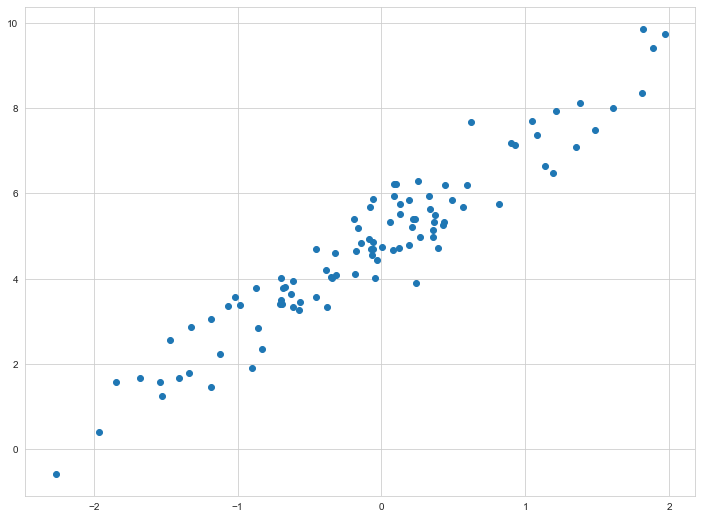

In [108]:
plt.scatter(X, y);

In [109]:
custom_lin_reg = CustomLinearRegression()

In [110]:
custom_lin_reg.fit(X, y)

My custom linear regression

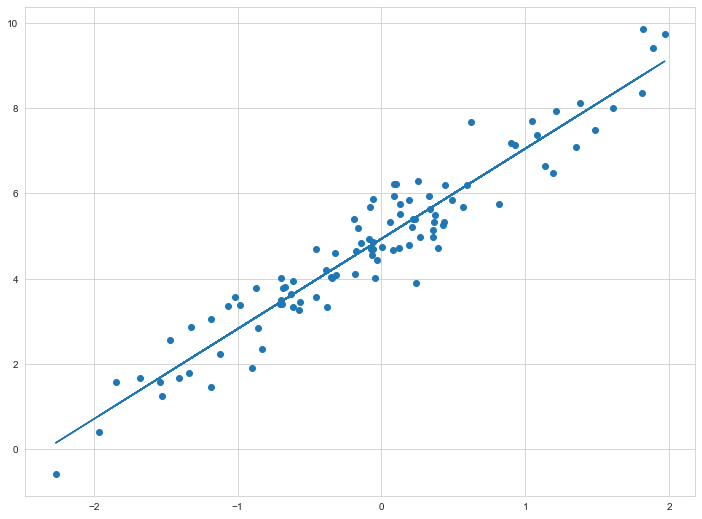

In [111]:
plt.scatter(X, y)
plt.plot(X, custom_lin_reg.predict(X));

#### Задание 2.3. Используем встроенную линейную регрессию (4 балла)

Поработаем с данными о ценах на дома в Калифорнии. Постройте модель линейной регресии при помощи `LinearRegression` из `sklearn`. Не забудьте разделить данные на тренировочную и тестовую части, а также правильно предобработать признаки. В конце воспользуйтесь какими-то изученными метриками регресии и сделайте выводы о качестве полученной модели, а также о том, какие признаки наиболее важны с точки зрения полученной модели.

In [589]:
data = fetch_california_housing()
X, y = data["data"], data["target"]
feature_names = data["feature_names"]

Ваш ход:

##### Ходим: познакомимся с данными

In [590]:
print(fetch_california_housing().DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

Познакомились. Теперь проверим, какие из них записаны неправильно или категриальные

In [591]:
data_df = pd.DataFrame(X, columns = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude'])
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB


In [592]:
data_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


Ура, никакие - просто будет стандартизировать. Прверим NA

In [593]:
data_df.isna().sum()

MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
dtype: int64

Их тоже нет, теперь проведем EDA

##### EDA

Изучим описательную статистику и распределение таргета

In [594]:
data_df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000


<AxesSubplot:ylabel='Density'>

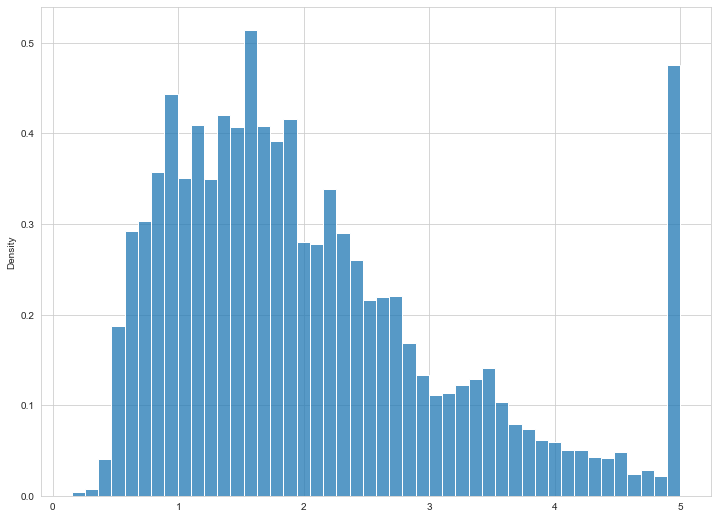

In [595]:
sns.histplot(y, stat='density')

Заметно, что распределение значений таргета не является нормальным, вероятно, есть какая-то верхняя граница цены домов, выше которой она не поднимается. Поэтому, скорее всего, наша линейная модель будет перепредсказывать значения, приближенные к реальному максимуму

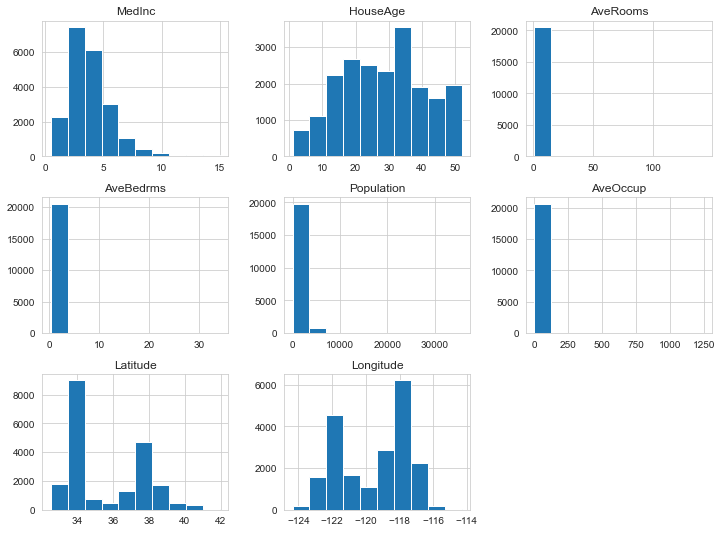

In [596]:
data_df.hist(figsize=(12, 9))
plt.subplots_adjust()

Проверим корреляцию внутри переменных

In [597]:
correlation_matrix = data_df.corr()
correlation_matrix

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
MedInc,1.000000,-0.119034,0.326895,-0.062040,0.004834,0.018766,-0.079809,-0.015176
HouseAge,-0.119034,1.000000,-0.153277,-0.077747,-0.296244,0.013191,0.011173,-0.108197
AveRooms,0.326895,-0.153277,1.000000,0.847621,-0.072213,-0.004852,0.106389,-0.027540
AveBedrms,-0.062040,-0.077747,0.847621,1.000000,-0.066197,-0.006181,0.069721,0.013344
Population,0.004834,-0.296244,-0.072213,-0.066197,1.000000,0.069863,-0.108785,0.099773
AveOccup,0.018766,0.013191,-0.004852,-0.006181,0.069863,1.000000,0.002366,0.002476
Latitude,-0.079809,0.011173,0.106389,0.069721,-0.108785,0.002366,1.000000,-0.924664
Longitude,-0.015176,-0.108197,-0.027540,0.013344,0.099773,0.002476,-0.924664,1.000000


<AxesSubplot:>

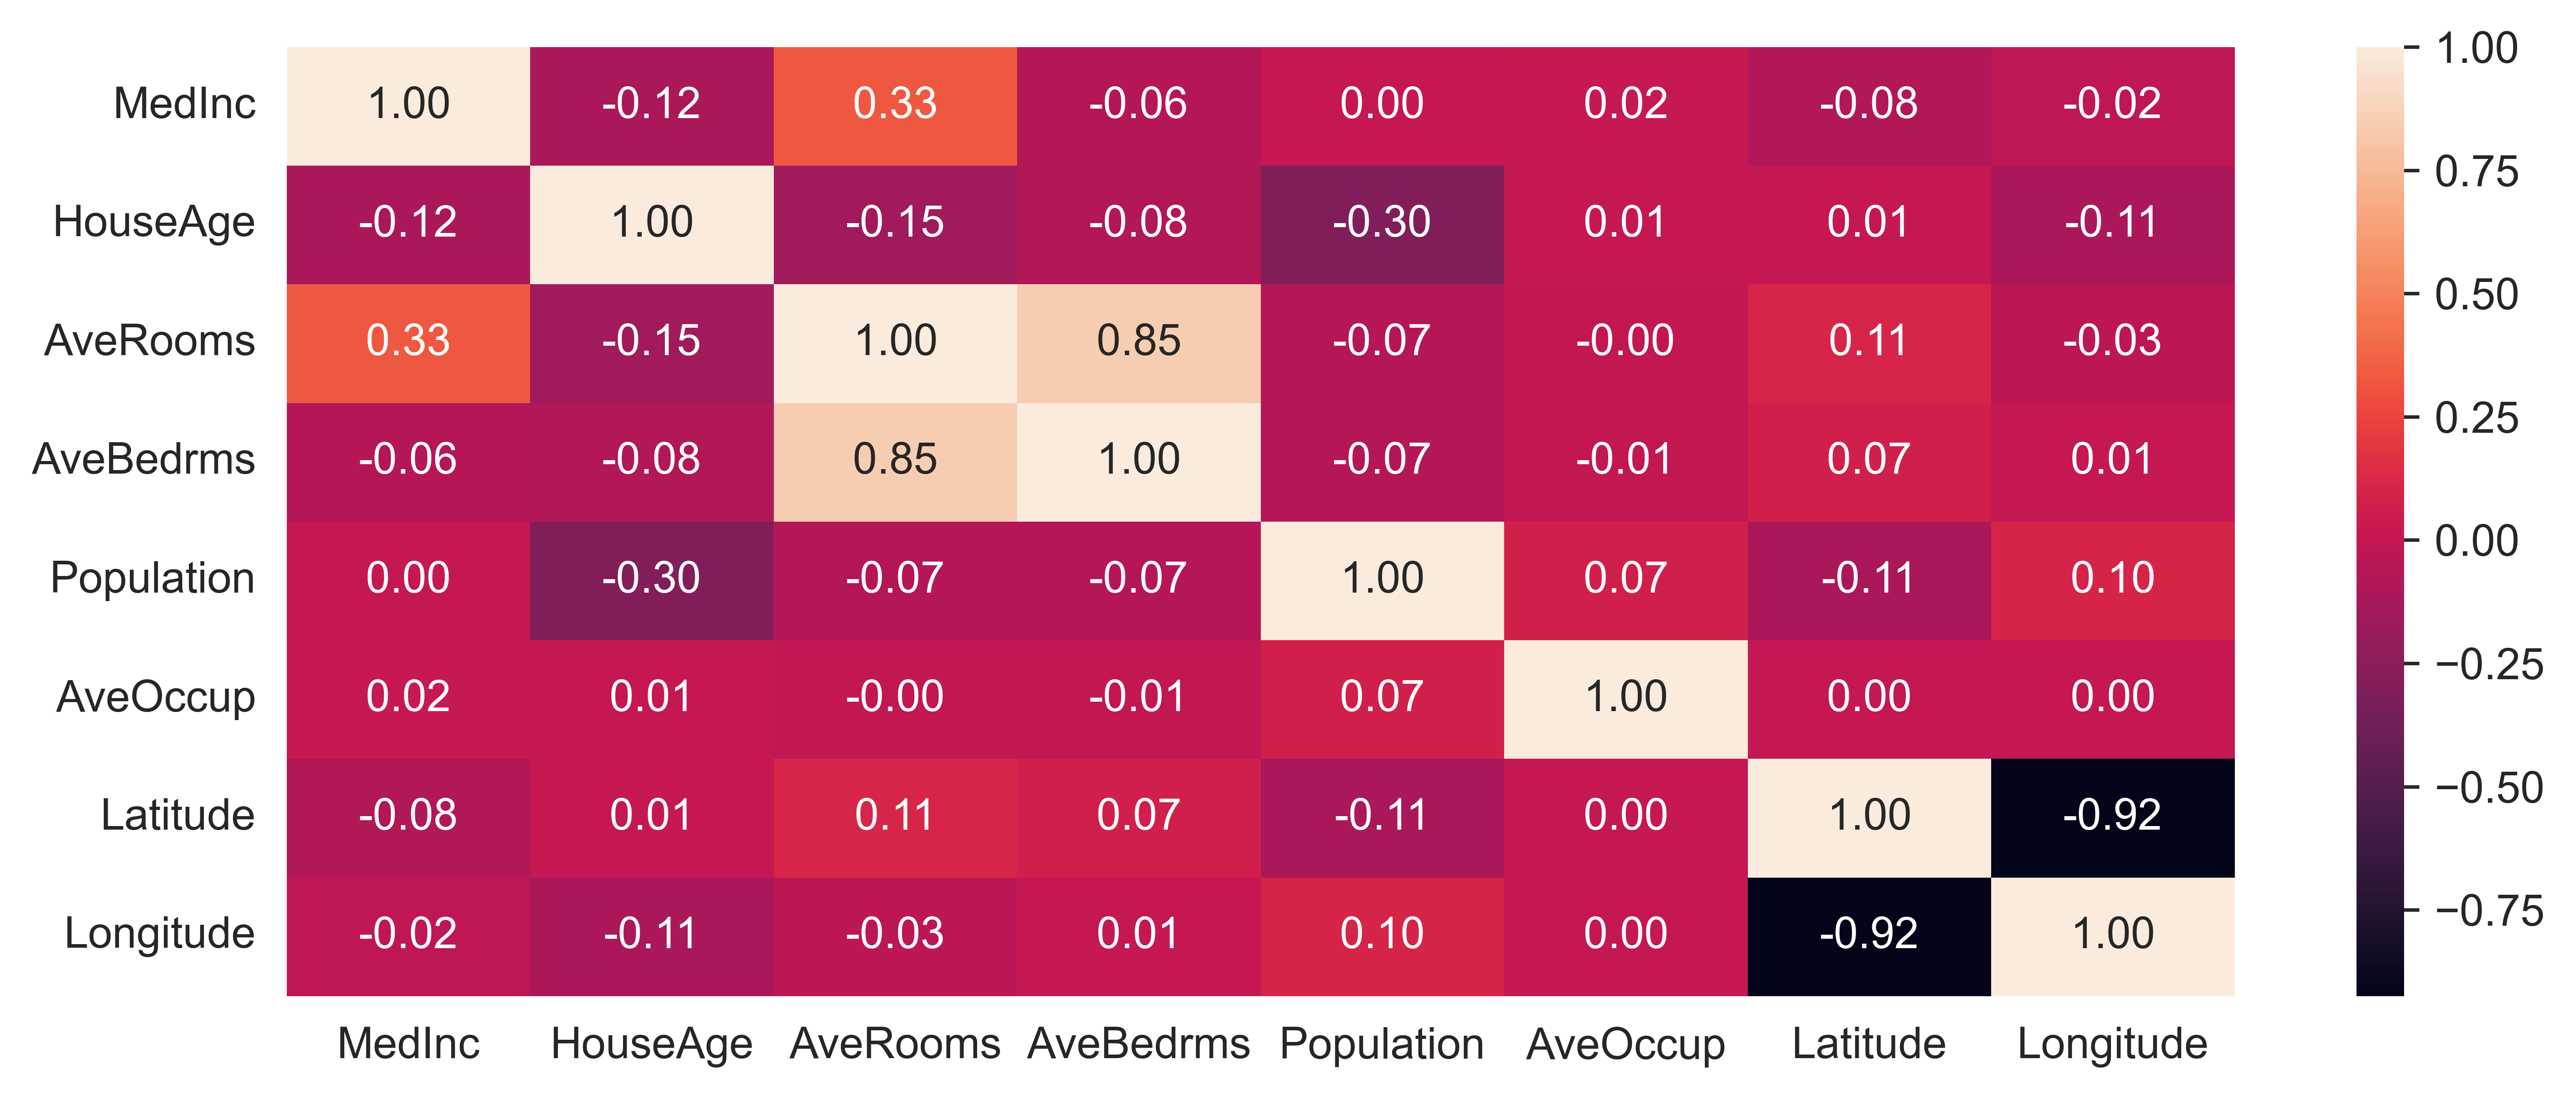

In [598]:
plt.figure(figsize=[10,4], dpi=700)
sns.heatmap(data=correlation_matrix, annot=True, fmt=".2f")

Широта и долгота имеют сильно выраженную отрицательную зависимость, поэтому стоит убрать один из предикторов. Аналогичная ситуация со средним числом комнат и ванн, только корреляция положительная

In [599]:
X = data_df
X = X.drop(['AveBedrms', 'Longitude'], axis=1)

##### Предсказания

Приступим к предсказаниям. Но надо немного подождать - сперва стандартизация данных

In [600]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(transformers=[
    ("scaler", StandardScaler(), list(X.columns))])
preprocessor.transformers

[('scaler',
  StandardScaler(),
  ['MedInc', 'HouseAge', 'AveRooms', 'Population', 'AveOccup', 'Latitude'])]

Пайплайн из стандартизации и линейной регрессии

In [601]:
regr = LinearRegression()
calif_pipeline = Pipeline([("preprocessor", preprocessor), ('regression', regr)])

Разделим данные на тестовые и тренировочные

In [602]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=SEED, 
                                                    test_size=0.2)

In [603]:
calif_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['MedInc', 'HouseAge',
                                                   'AveRooms', 'Population',
                                                   'AveOccup', 'Latitude'])])),
                ('regression', LinearRegression())])

Получим предсказанные значения

In [604]:
y_pred = calif_pipeline.predict(X_test)
y_pred

array([1.10777312, 0.94536451, 1.8277449 , ..., 2.19469273, 2.31827649,
       3.92129291])

А теперь посмотрим на метрические показатели

In [605]:
r2_score(y_test, y_pred)

0.5032390488773841

In [606]:
mean_squared_error(y_test, y_pred)

0.6648951891632682

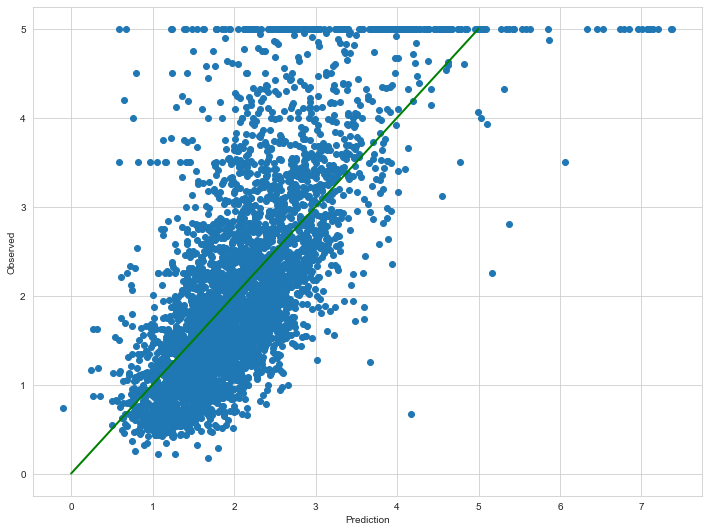

In [607]:
plt.scatter(y_pred, y_test)
plt.plot(np.arange(0, 6, 1), np.arange(0, 6, 1), color='green', linewidth=2)
plt.xlabel('Prediction')
plt.ylabel('Observed');

Зададим верхний лимит

In [608]:
y_pred_image = y_pred.copy()
y_pred_image[y_pred_image > 5] = 5

In [609]:
print(f'R2 {r2_score(y_test, y_pred_image)}')
print(f'MSE {mean_squared_error(y_test, y_pred_image)}')

R2 0.5164986749686051
MSE 0.6471476959711545


Модель предсказывает не самым качественным образом, возможно, не стоило удалять фичи, которык дают корреляцию. Это вероятно, позволило увидеть более значимые факторы, но ухудшило качетво предсказания. 
Как и ожидалось, модель плохо предсказывает верхние значения (после поправки на верхний лимит стало немного лучше). Еще и нижние недопредсказывает

### Задание 3. Реализация логистической регресии (суммарно 10 баллов)

Логистическая регрессия не очень сильно отличается от обычной линейной регрессии и используется в задах классификации. Так как здесь мы снова будем пользоваться градиентным спуском, то нужно определить функцию потерь и ее градиент. Одним из самых популярных вариантов в задаче бинарной классификации является бинарная кросс-энтропия (BCE).

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Единственная проблема данной функции это возможность получить 0 под знаком логарифма, что не очень хорошо. Попробуем справить с этим "в лоб". Скажем, что наши предсказания могут принимать значения от 0 + eps до 1 - eps, где eps очень маленькое число.

#### Задание 3.1. Реализация сигмоиды (0.5 баллов)

Реализуйте функцию `sigmoid`, которая переводит действительное число $\mathbb R$ в вероятность $[0,1]$.

In [236]:
def sigmoid(output):
    # output результат X@w (-inf, +inf)
    """
    YOUR CODE IS HERE
    """
    return 1/(1 + np.exp(-output))

#### Задание 3.2. BCE Loss и ее градиент (2.5 балла)

Так как мы с вами только начинаем изучать машинное обучение, то было бы слишком жестоко просить вас вычислить градиент BCE Loss (он не так сложен, просто нужно привыкнуть). Поэтому сразу напишем формулу для него:

$$
\nabla{\mathcal L_{BCE}(y, \hat y), X} = X^T (\sigma({\hat{y}}) - y)
$$

In [253]:
def bce(y_true, y_pred, eps=1e-15):
    """
    Функция потерь BCE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов 0/1
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели (вероятности)
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    n = y_true.shape[0]
    
    # So I want escape log(0)
    y_pred = np.clip(y_pred, eps, 1 - eps)
    
    """
    YOUR CODE IS HERE
    """
    return (-1/y_true.shape[0]) * (np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred)))

def bce_grad(y_true, y_pred, X):
    """
    Функция потерь BCE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов 0/1
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели (вероятности)
        :param X: np.array[n_samples, n_features]: матрица объекты x признаки
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    """
    YOUR CODE IS HERE
    """
    return X.transpose() @ (y_pred - y_true)


class BCELoss:
    """
    Класс, реализующий функцию потерь BCE. Нужен для того, чтобы
    объединять в одном месте функцию потерь и градиент для нее.
    """
    
    def __call__(self, y_true, y_pred):
        return bce(y_true, y_pred)
    
    def calculate_gradient(self, y_true, y_pred, X):
        return bce_grad(y_true, y_pred, X)

#### Задание 3.3. Предсказания логистической регрессии (2 балла)

Реализуйте метод `predict` у класса `CustomLogisticRegression`, не забудьте про свободный член!

In [260]:
class CustomLogisticRegression(BaseLinearModel):
    def __init__(self, learning_rate: float = 1e-3,
                 loss_function=BCELoss(), fit_intercept=True,
                 n_iter=1000, tol=1e-5, optimizer=BasicGradientDescent, grad_norm="l1"):
        
        super().__init__(learning_rate=learning_rate,
                         loss_function=loss_function, fit_intercept=fit_intercept,
                         n_iter=n_iter, tol=tol, optimizer=optimizer, grad_norm=grad_norm)
    
    
    def predict(self, X_test):
        if self.W is None:
            raise NotFittedError("This CustomLogisticRegression instance is not fitted, run fit method.")
        
        n_test_samples = X_test.shape[0]
        if self.fit_intercept:
            ones_column = np.ones((n_test_samples, 1))
            X_test = np.hstack((ones_column, X_test))
            
        """
        YOUR CODE IS HERE
        """
        return sigmoid(X_test @ self.W)
    
    
    def __repr__(self):
        return "My custom logistic regression"

#### Снова проверим работу алгоритма на простом примере

In [612]:
# Создадим датасет из 1 признака и 2 классов
X, y = make_classification(n_features=1, n_informative=1,
                           n_redundant=0, n_clusters_per_class=1)

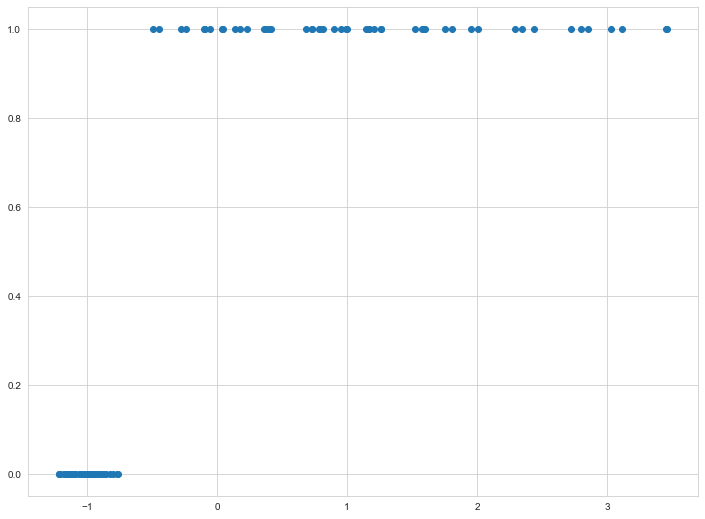

In [613]:
plt.scatter(X, y);

In [614]:
custom_log_reg = CustomLogisticRegression()
custom_log_reg.fit(X, y)
y_pred = custom_log_reg.predict(X)

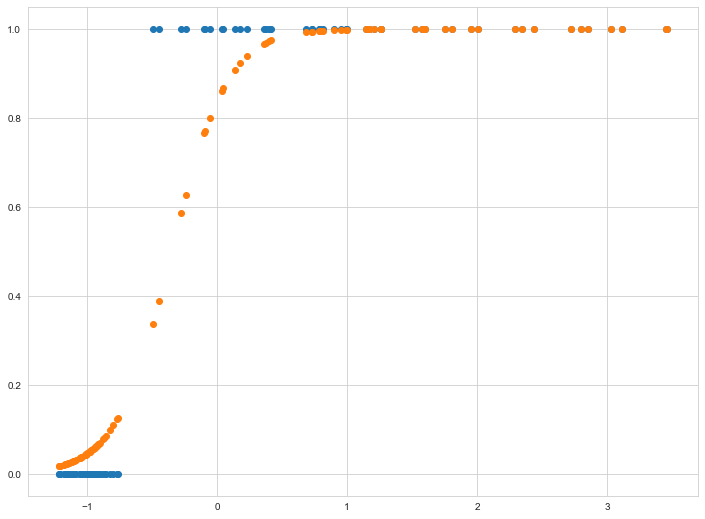

In [615]:
plt.scatter(X, y)
plt.scatter(X, y_pred);

Проверьте качество работы модели при помощи известных вам метрик бинарной классификации.

In [616]:
bce(y, y_pred)

264.04512405925203

In [619]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y, y_pred)

1.0

Судя по метрикам, модель дейсвительно очень хорошо работает (но это всего 1 фича)

#### Задание 3.4. Применение логистической регрессии (5 баллов)

Мы будем использовать данные по свойствам покемонов (https://www.kaggle.com/abcsds/pokemon). В данном задании вам необходимо сначала сделать краткий EDA (Посмотреть на данные и их распределения, а также посмотреть, как различные признаки связаны между собой и с целевой переменной (`Legendary`)).

In [486]:
pokemon = pd.read_csv("Pokemon.csv")
pokemon.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


Мы будем предсказывать является ли покемон легендарным или нет. Замените логическое значение колонки на числовое (перекодировав на 0 и 1). Также подумайте, как в этом случае лучше закодировать категориальные признаки (может быть, лучше их просто выбросить?).

In [487]:
pokemon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        800 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      414 non-null    object
 4   Total       800 non-null    int64 
 5   HP          800 non-null    int64 
 6   Attack      800 non-null    int64 
 7   Defense     800 non-null    int64 
 8   Sp. Atk     800 non-null    int64 
 9   Sp. Def     800 non-null    int64 
 10  Speed       800 non-null    int64 
 11  Generation  800 non-null    int64 
 12  Legendary   800 non-null    bool  
dtypes: bool(1), int64(9), object(3)
memory usage: 75.9+ KB


Удаляем фичи, которые точно ничего не значат

In [488]:
pokemon = pokemon.drop(['#', 'Name'], axis = 1)

С Total сложно сказать. Само по себе это значение бессмысленно, но что если легендарность дается только тогда, когда у тебя высокая сумма независимо от конкретной компоненты или их распределения. Тогда, если выкинуть, регрессия не даст нам хорошее предсказание. Решил пока оставить, в конце сравнить.

Бегло пострараемся оценить, насколько это может быть близким к правде

In [489]:
pokemon[pokemon['Legendary'] == True].head(10)

,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
156,Ice,Flying,580,90,85,100,95,125,85,1,True
157,Electric,Flying,580,90,90,85,125,90,100,1,True
158,Fire,Flying,580,90,100,90,125,85,90,1,True
162,Psychic,NaN,680,106,110,90,154,90,130,1,True
163,Psychic,Fighting,780,106,190,100,154,100,130,1,True
164,Psychic,NaN,780,106,150,70,194,120,140,1,True
262,Electric,NaN,580,90,85,75,115,100,115,2,True
263,Fire,NaN,580,115,115,85,90,75,100,2,True
264,Water,NaN,580,100,75,115,90,115,85,2,True
269,Psychic,Flying,680,106,90,130,90,154,110,2,True


In [490]:
pokemon[pokemon['Legendary'] != True].head(10)

,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,Grass,Poison,318,45,49,49,65,65,45,1,False
1,Grass,Poison,405,60,62,63,80,80,60,1,False
2,Grass,Poison,525,80,82,83,100,100,80,1,False
3,Grass,Poison,625,80,100,123,122,120,80,1,False
4,Fire,NaN,309,39,52,43,60,50,65,1,False
5,Fire,NaN,405,58,64,58,80,65,80,1,False
6,Fire,Flying,534,78,84,78,109,85,100,1,False
7,Fire,Dragon,634,78,130,111,130,85,100,1,False
8,Fire,Flying,634,78,104,78,159,115,100,1,False
9,Water,NaN,314,44,48,65,50,64,43,1,False


Вероятно, это всё-таки переменная, которую можно удалить, но пока оставим

In [491]:
pokemon["Legendary"] = pokemon["Legendary"].astype(int)

In [493]:
pokemon.Legendary.sum()

65

Логично, что легендарных будет мало, поэтому будем проводить over-sampling

Выделим категориальные признаки

In [494]:
print(pokemon['Type 1'].unique())
print(pokemon['Type 2'].unique())
print(pokemon['Generation'].unique())

['Grass' 'Fire' 'Water' 'Bug' 'Normal' 'Poison' 'Electric' 'Ground'
 'Fairy' 'Fighting' 'Psychic' 'Rock' 'Ghost' 'Ice' 'Dragon' 'Dark' 'Steel'
 'Flying']
['Poison' nan 'Flying' 'Dragon' 'Ground' 'Fairy' 'Grass' 'Fighting'
 'Psychic' 'Steel' 'Ice' 'Rock' 'Dark' 'Water' 'Electric' 'Fire' 'Ghost'
 'Bug' 'Normal']
[1 2 3 4 5 6]


In [492]:
pokemon.isna().sum()

Type 1          0
Type 2        386
Total           0
HP              0
Attack          0
Defense         0
Sp. Atk         0
Sp. Def         0
Speed           0
Generation      0
Legendary       0
dtype: int64

Очень соблазительно выкинуть Тип 1 и оставить только 2 как показатель для легендарности

In [495]:
pokemon[pokemon['Legendary'] == True]['Type 1'].value_counts()

Psychic     14
Dragon      12
Fire         5
Electric     4
Water        4
Rock         4
Steel        4
Ground       4
Grass        3
Ice          2
Normal       2
Ghost        2
Dark         2
Flying       2
Fairy        1
Name: Type 1, dtype: int64

In [496]:
pokemon[pokemon['Legendary'] == True]['Type 2'].value_counts()

Flying      13
Psychic      5
Fighting     4
Dragon       4
Fire         3
Ice          3
Fairy        2
Steel        1
Electric     1
Ground       1
Ghost        1
Dark         1
Water        1
Name: Type 2, dtype: int64

Похоже, что Легендарные чаще являются Драконами-Экстрасенсами (мб тут стоит придумать шутку, но я не придумал) по 1 типу и Летающими по 2, поэтому оставим обе эти переменные. В идеальном варианте, надо сделать, чтобы при стандартизации в обоих колонках лейбл был эквивалентный

In [497]:
cat_cols = ['Type 1', 'Type 2', 'Generation']

num_cols = ['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk',
            'Sp. Def', 'Speed']

all_features = cat_cols + num_cols

target = pokemon['Legendary'].values

Проверим распределение численных переменных - вполне себе хорошее

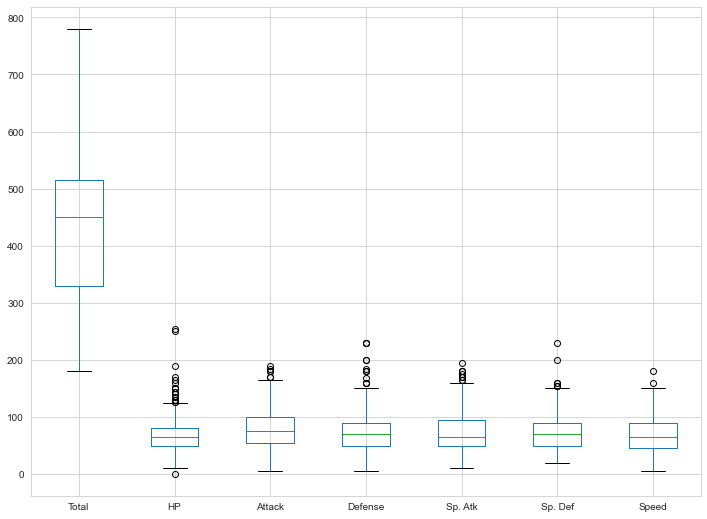

In [498]:
pokemon[num_cols].boxplot();

##### Предсказания

In [499]:
X = pokemon[all_features]
y = target

In [550]:
preprocessor = ColumnTransformer(transformers=[
    ("scaler", StandardScaler(), num_cols),
    ("ohe", OneHotEncoder(), cat_cols)
])

log_regression = LogisticRegression()

In [551]:
pokemon_pipeline = Pipeline(steps=[
                            ("preprocessor", preprocessor),
                            ("regression", log_regression)
                            ])

Разделите ваши данные на тестовую и тренировочную выборкую 
> Я не нашел, как поделить на 4 группы с over-sampling, зато нашел, что можно применить stratify

In [552]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=SEED, stratify = y)

Обучите модель `LogisticRegression` из `sklearn`.

In [553]:
pokemon_pipeline.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['Total', 'HP', 'Attack',
                                                   'Defense', 'Sp. Atk',
                                                   'Sp. Def', 'Speed']),
                                                 ('ohe', OneHotEncoder(),
                                                  ['Type 1', 'Type 2',
                                                   'Generation'])])),
                ('regression', LogisticRegression())])

Проведем предсказание как по классам, так и вероятности отнесения к какому-либо классу

In [554]:
y_pred = pokemon_pipeline.predict(x_test)
y_pred

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0])

In [555]:
y_pred_proba = pokemon_pipeline.predict_proba(x_test)

##### Качество модели

In [556]:
roc_auc_score(y_test, y_pred)

0.7024456521739131

In [557]:
from sklearn.metrics import (accuracy_score, f1_score)

accuracy_score(y_test, y_pred)

0.925

In [558]:
f1_score(y_test, y_pred)

0.4827586206896552

В целом, модель хорошо предсказывает судя по доле правильных ответов, но Легендарных исходно мало и если, даже не изучая регрессию, просто говорить на случайного покемона - обычный, то я получу высокий процент. А вот F-score показывает, что ошибки 1 и 2 рода не такое уж редкое явление для разработанной модели

Выведите метрики вашего классификатора:

1. Нарисуйте [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html).

2. Изобразите ROC кривую и посчитайте площадь под ней.

3. Скажите, какие признаки оказались наиболее важны для модели.

1. Confusion matrix

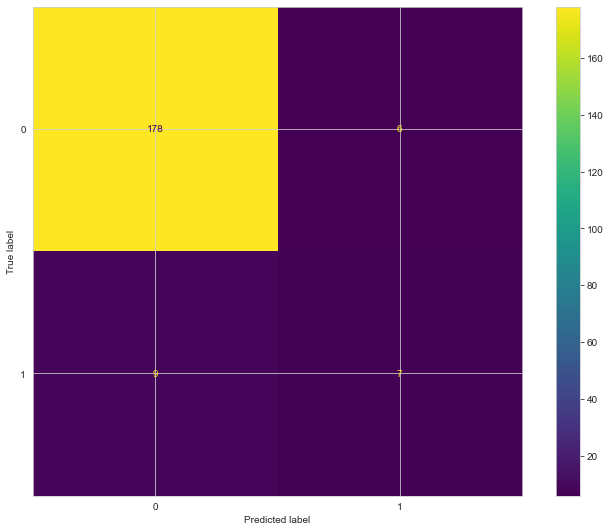

In [559]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
matrix = confusion_matrix(y_test, y_pred, labels=pokemon_pipeline['regression'].classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=pokemon_pipeline['regression'].classes_)
disp.plot();

Как и ожидалось, модель совершает ошибку 1 или 2 рода практически в таком же количестве, как и при верном угадывании Легендарных

2. ROC curve

In [561]:
from sklearn.metrics import (RocCurveDisplay, roc_curve, auc)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])
roc_auc = auc(fpr, tpr)

In [562]:
roc_auc

0.9663722826086956

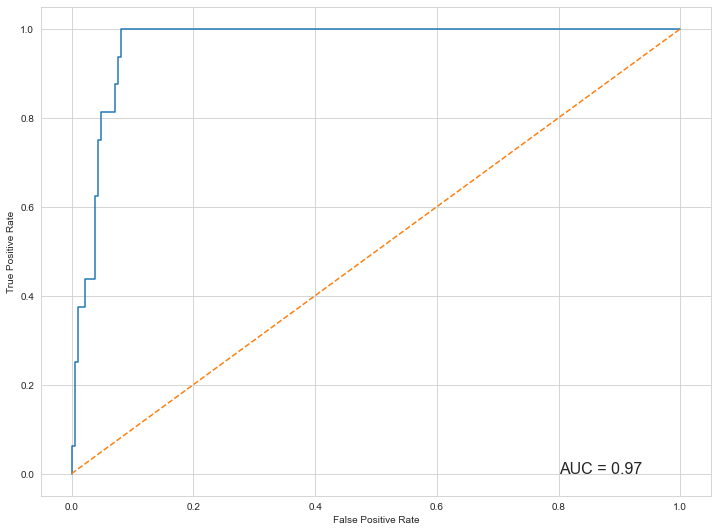

In [563]:
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.text(0.8, 0, s = f'AUC = {round(roc_auc, 2)}', fontsize=16) 
plt.show()

А ROC как раз выглядит хорошо за счет большого количества неЛегендарных

3. Коэффиценты

In [585]:
coefs = pokemon_pipeline.named_steps['regression'].coef_.flatten()
feature_names = pokemon_pipeline.named_steps['preprocessor'].get_feature_names_out()
zipped = zip(feature_names, coefs)
df= pd.DataFrame(zipped, columns=["feature", "value"])
df

,feature,value
0,scaler__HP,1.192401
1,scaler__Attack,0.688942
2,scaler__Defense,1.138508
3,scaler__Sp. Atk,1.154205
4,scaler__Sp. Def,1.264219
5,scaler__Speed,1.371000
6,ohe__Type 1_Bug,-0.499117
7,ohe__Type 1_Dark,-0.200393
8,ohe__Type 1_Dragon,0.055231
9,ohe__Type 1_Electric,0.513700


Посмотрим на абсолютные значения

In [586]:
df["abs_value"] = df["value"].apply(lambda x: abs(x))
df["colors"] = df["value"].apply(lambda x: "green" if x > 0 else "red")
df = df.sort_values("abs_value", ascending=False)

Text(0.5, 0, 'Feature Name')

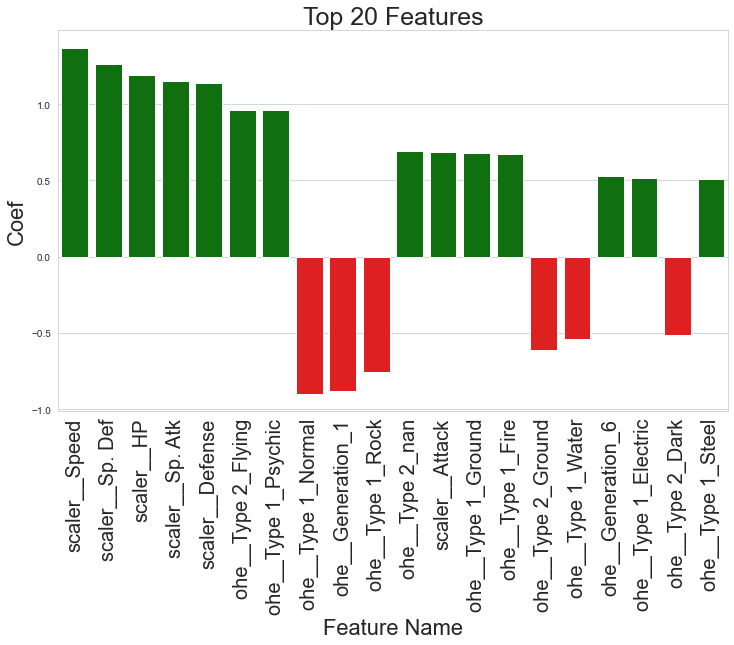

In [587]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.barplot(x="feature",
            y="value",
            data=df.head(20),
           palette=df.head(20)["colors"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
ax.set_title("Top 20 Features", fontsize=25)
ax.set_ylabel("Coef", fontsize=22)
ax.set_xlabel("Feature Name", fontsize=22)

В итоге самыми важными показателями являются количественные показатели (кроме, общего и обычной атаки). Еще больше Легендарных среди Летающих 2 тип и Психических 1 тип. И не стоит быть нормальным

Попробовал удалить Total - нет изменений в предсказаниях

In [565]:
pokemon_alt = pokemon
pokemon_alt = pokemon_alt.drop(['Total'], axis = 1)
pokemon_alt

,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,Grass,Poison,45,49,49,65,65,45,1,0
1,Grass,Poison,60,62,63,80,80,60,1,0
2,Grass,Poison,80,82,83,100,100,80,1,0
3,Grass,Poison,80,100,123,122,120,80,1,0
4,Fire,NaN,39,52,43,60,50,65,1,0
...,...,...,...,...,...,...,...,...,...,...
795,Rock,Fairy,50,100,150,100,150,50,6,1
796,Rock,Fairy,50,160,110,160,110,110,6,1
797,Psychic,Ghost,80,110,60,150,130,70,6,1
798,Psychic,Dark,80,160,60,170,130,80,6,1


In [566]:
num_cols_alt = ['HP', 'Attack', 'Defense', 'Sp. Atk',
                'Sp. Def', 'Speed']

all_features_alt = cat_cols + num_cols_alt
X_alt = pokemon_alt[all_features_alt]
y_alt = target

In [576]:
preprocessor = ColumnTransformer(transformers=[
    ("scaler", StandardScaler(), num_cols_alt),
    ("ohe", OneHotEncoder(), cat_cols)
])

log_regression = LogisticRegression()

In [577]:
pokemon_pipeline = Pipeline(steps=[
                            ("preprocessor", preprocessor),
                            ("regression", log_regression)
                            ])

Разделите ваши данные на тестовую и тренировочную выборку.

In [578]:
x_train_alt, x_test_alt, y_train_alt, y_test_alt = train_test_split(X_alt, y, test_size=0.25, random_state=SEED, stratify = y)

Обучите модель `LogisticRegression` из `sklearn`.

In [579]:
pokemon_pipeline.fit(x_train_alt, y_train_alt)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['HP', 'Attack', 'Defense',
                                                   'Sp. Atk', 'Sp. Def',
                                                   'Speed']),
                                                 ('ohe', OneHotEncoder(),
                                                  ['Type 1', 'Type 2',
                                                   'Generation'])])),
                ('regression', LogisticRegression())])

In [580]:
y_pred_alt = pokemon_pipeline.predict(x_test_alt)
y_pred_alt

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0])

Выведите метрики вашего классификатора:

1. Нарисуйте [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html).

2. Изобразите ROC кривую и посчитайте площадь под ней.

3. Скажите, какие признаки оказались наиболее важны для модели.

In [581]:
from sklearn.metrics import confusion_matrix
matrix_alt = confusion_matrix(y_test_alt, y_pred_alt)
matrix_alt

array([[178,   6],
       [  9,   7]], dtype=int64)

In [582]:
roc_auc_score(y_test_alt, y_pred_alt)

0.7024456521739131

In [583]:
accuracy_score(y_test_alt, y_pred_alt)

0.925

In [584]:
f1_score(y_test_alt, y_pred_alt)

0.4827586206896552

### Задание 4. Расскажите о вашей любимой музыкальной группе (исполнителе) (0.5 балла)

Расскажите, как вы познакомились с этой группой и скиньте несколько наиболее любимых треков)

Очень люблю 21 pilots, особенно альбомы Trench и Blurryface. А познакомился впервые лет в 15, когда увидил пост в вк с той самой шуткой, где остальные 19. И стало интересно узнать больше о них, и с тех пор слушаю и лайкаю каждый пост с этим уже приевшимся приколом)

https://www.youtube.com/watch?v=Io2hbcrAYBw&ab_channel=twentyonepilots

https://www.youtube.com/watch?v=UOUBW8bkjQ4&ab_channel=twentyonepilots

https://www.youtube.com/watch?v=MiPBQJq49xk&list=OLAK5uy_mWtWynXa5NeLQEJjvrmVZmmO48G4eBBWg&index=9&ab_channel=twentyonepilots

## Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз. 

**Ваши мысли:**

Было очень интересно) 

Не то чтобы сложно, но иногда приходилось долго пытаться. Пойду доделывать первую)